In [1]:
# -*- coding: utf-8 -*-

'''
Reference:
This script was inspired by a Kaggle Kernel which includes a step-by-step Python/PyTorch solution
for analysing Chest X-Ray images. Some modifications and additions were made to adapt the script
to the specific environment and resolve certain errors that appeared during the creation process.

If you wish, you can check out the original work here:
VassiliPH, [2023]. Chest X-Ray Images - PyTorch Step by Step (Acc ~94%). Kaggle.
Available at: https://www.kaggle.com/code/vassiliph/chest-xray-images-pytorch-step-by-step-acc-94 [Accessed 7 Dec. 2024].
'''

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import zipfile
import os
from google.colab import drive
import shutil
from tqdm import tqdm
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import pandas as pd


drive.mount('/content/drive')

colab_notebooks_path = '/content/drive/MyDrive/Colab_Notebooks'

sys.path.append(colab_notebooks_path)

DATASET_LOCATION = '/content/chest_xray'
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

!mkdir -p ~/Downloads
!curl -L -o ~/Downloads/chest-xray-pneumonia.zip \
  https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

!unzip -q -o ~/Downloads/chest-xray-pneumonia.zip -d {DATASET_LOCATION}

print(f"Dataset location: {DATASET_LOCATION}")

Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0  22.5M      0  0:01:44  0:01:44 --:--:-- 22.5M
Dataset location: /content/chest_xray


In [2]:
# In case there is not available path for custom utils
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Define the base directory for the nested chest_xray dataset
# I've used this path to avoid encountering issues with the dataset structure
nested_chest_xray_dir = '/content/chest_xray/chest_xray'

# Loop through each dataset split (train, validation, test)
for subdir in ['train', 'val', 'test']:
    # Create full source path
    src_dir = os.path.join(nested_chest_xray_dir, subdir)
    # Create full destination path
    dest_dir = os.path.join('/content/chest_xray', subdir)

    # Check if the source directory exists and the destination directory doen't
    if os.path.exists(src_dir) and not os.path.exists(dest_dir):
        # Move the entire subdirectory and its contents to the new location
        shutil.move(src_dir, dest_dir)
        print(f"Moved {src_dir} to {dest_dir}")
    else:
        print(f"Skipping move for {src_dir} - either source doesn't exist or destination already exists.")

# Verify the structure of the dataset
for subdir in ['train', 'val', 'test']:
    subdir_path = os.path.join('/content/chest_xray', subdir)

    # Check if the directory exists before listing its contents
    if os.path.exists(subdir_path):
        print(f"Contents of {subdir_path}:")
        print(os.listdir(subdir_path))

        # Check for expected categories such as (NORMAL & PNEUMONIA) within each dataset split
        for category in ['NORMAL', 'PNEUMONIA']:
            category_path = os.path.join(subdir_path, category)
            if os.path.exists(category_path):
                print(f"  Found {category_path} - data in correct place")
            else:
                print(f"  Warning: {category_path} not found - dataset might be structured differently")
    else:
        print(f"Directory {subdir_path} does not exist.")

Moved /content/chest_xray/chest_xray/train to /content/chest_xray/train
Moved /content/chest_xray/chest_xray/val to /content/chest_xray/val
Moved /content/chest_xray/chest_xray/test to /content/chest_xray/test
Contents of /content/chest_xray/train:
['NORMAL', 'PNEUMONIA']
  Found /content/chest_xray/train/NORMAL - data in correct place
  Found /content/chest_xray/train/PNEUMONIA - data in correct place
Contents of /content/chest_xray/val:
['NORMAL', 'PNEUMONIA']
  Found /content/chest_xray/val/NORMAL - data in correct place
  Found /content/chest_xray/val/PNEUMONIA - data in correct place
Contents of /content/chest_xray/test:
['NORMAL', 'PNEUMONIA']
  Found /content/chest_xray/test/NORMAL - data in correct place
  Found /content/chest_xray/test/PNEUMONIA - data in correct place


In [8]:
from torchvision import datasets

# Transforms for training and testing datasets
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='/content/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/chest_xray/test', transform=transform)

# Check the class labels in the training dataset
print(train_dataset.class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Actual model and optimiser
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, len(train_dataset.classes))
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
model.train()
for epoch in range(10):
    running_loss = 0.0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")

# Model evaluation on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

{'NORMAL': 0, 'PNEUMONIA': 1}
Epoch [1]: Train Loss: 0.3775
Epoch [2]: Train Loss: 0.2168
Epoch [3]: Train Loss: 0.1603
Epoch [4]: Train Loss: 0.1453
Epoch [5]: Train Loss: 0.1412
Epoch [6]: Train Loss: 0.1360
Epoch [7]: Train Loss: 0.1288
Epoch [8]: Train Loss: 0.1226
Epoch [9]: Train Loss: 0.1202
Epoch [10]: Train Loss: 0.1217
Accuracy on the test set: 74.68%


In [9]:
from torch.utils.data import random_split, DataLoader
import torch
from tqdm import tqdm

# Tansforms for training and testing datasets
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='/content/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/chest_xray/test', transform=transform)

num_classes = len(train_dataset.classes)

# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader with drop_last=True to handle uneven batch sizes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

def evaluate_model(model, data_loader, dataset_size):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).type(torch.float).sum().item()

    accuracy = correct / dataset_size
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss

epochs = 10

# Training loop to move data to GPU
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

# Evaluate_model function on GPU
def evaluate_model(model, data_loader, dataset_size):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).type(torch.float).sum().item()

    accuracy = correct / dataset_size
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss

Epoch 10/10: 100%|██████████| 130/130 [00:56<00:00,  2.31it/s]


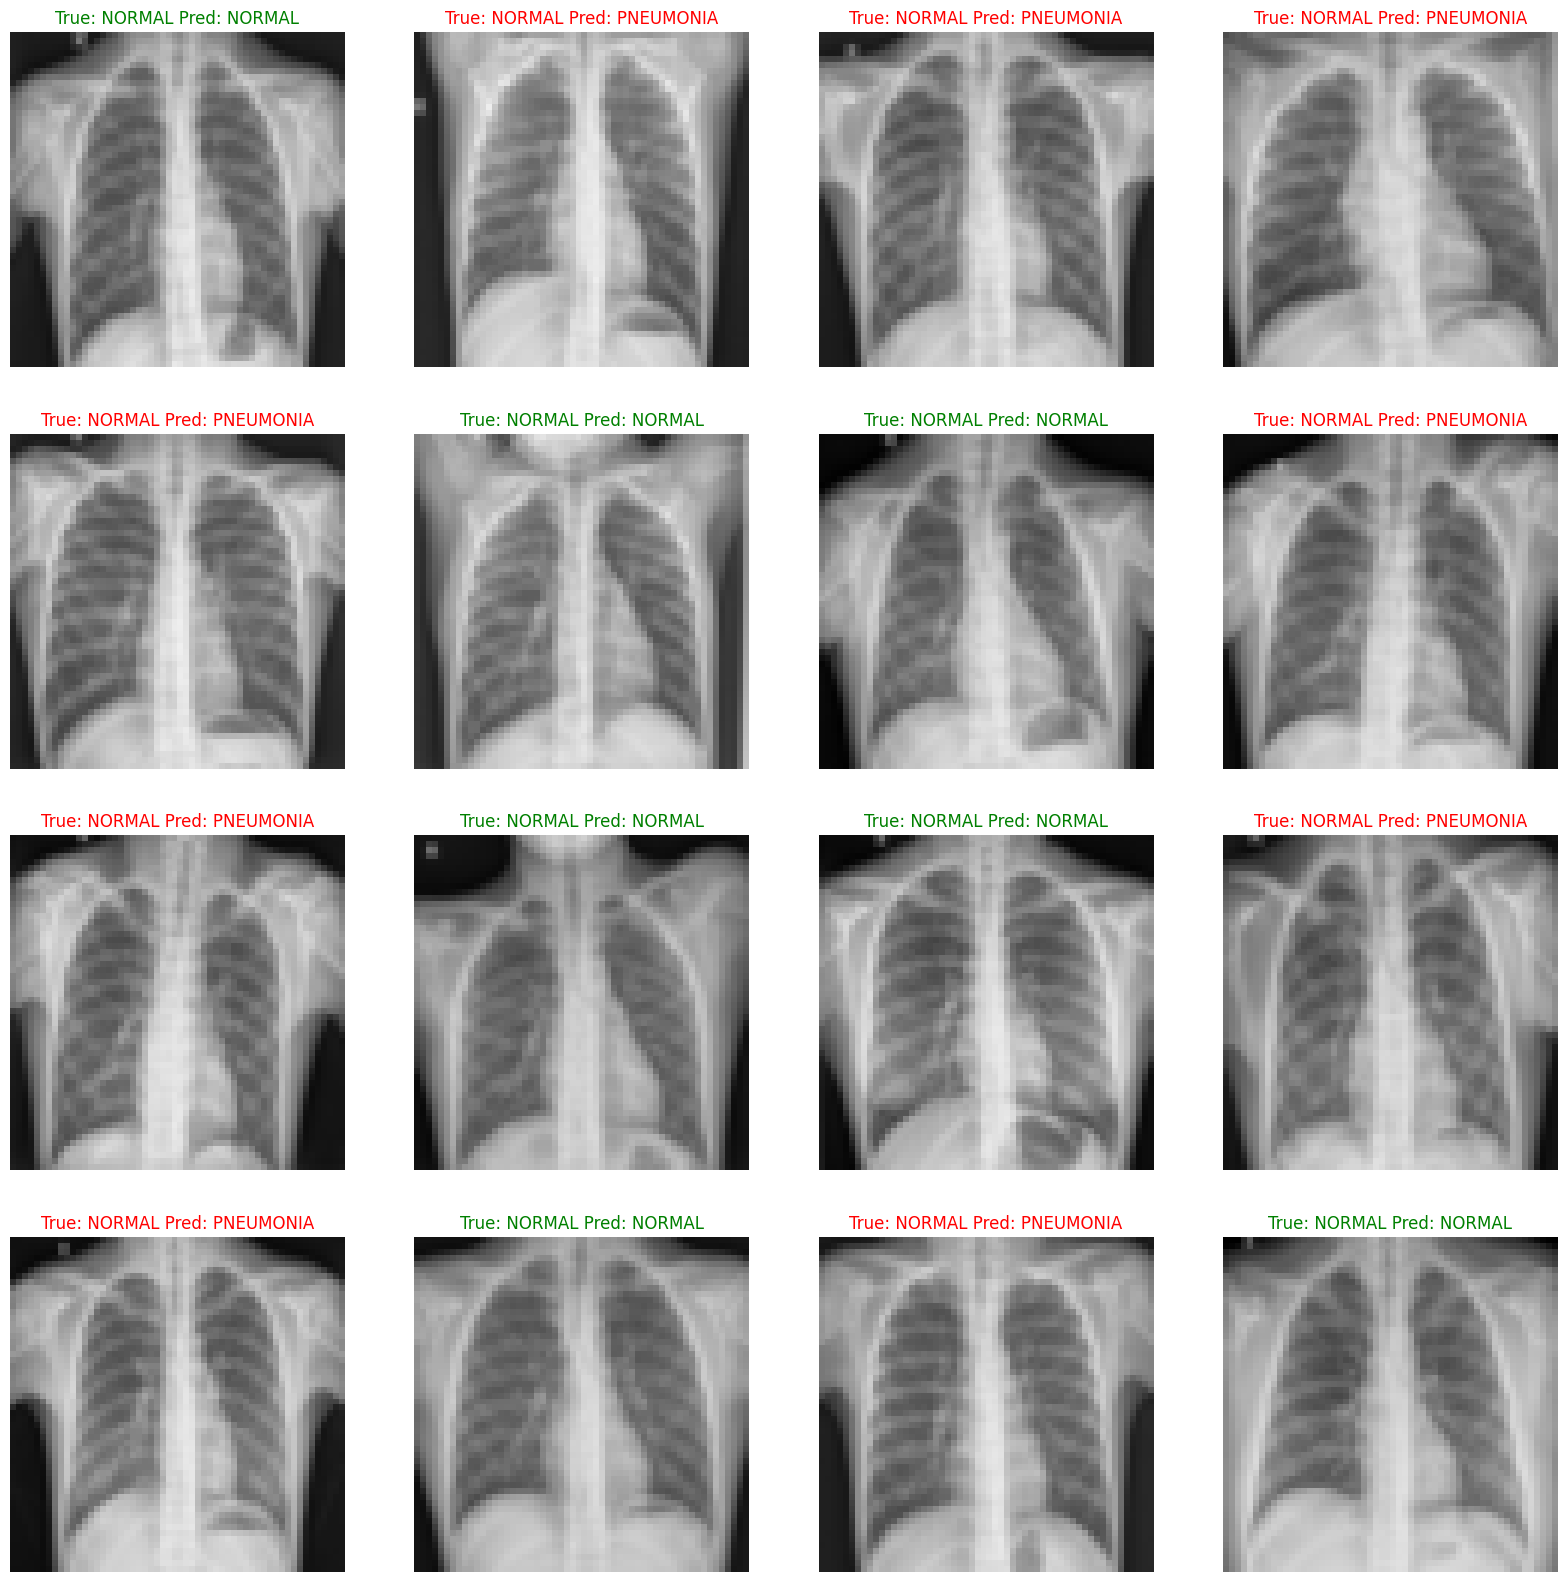

Batch Accuracy: 43.75%
Model device: cuda:0
Data device: cpu


In [10]:
# Ensure model is on GPU
device = torch.device('cuda')
model = model.to(device)

model.eval()

# Create test DataLoader with pin_memory for faster GPU transfer
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

# Get a batch of test images and move to GPU
images, true_labels = next(iter(test_loader))
images = images.to(device)
true_labels = true_labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

class_names = test_dataset.classes

# Move tensors back to CPU for visualisation
images = images.cpu()
true_labels = true_labels.cpu()
predicted = predicted.cpu()

# Visualisation
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i].permute(1, 2, 0)
    plt.imshow(image)

    true_class = class_names[true_labels[i]]
    pred_class = class_names[predicted[i]]

    # Colour code the title: green for correct predictions, red for wrong ones
    color = 'green' if true_labels[i] == predicted[i] else 'red'
    plt.title(f'True: {true_class} Pred: {pred_class}',
              color=color,
              fontsize=12)
    plt.axis('off')
plt.show()

accuracy = (predicted == true_labels).sum().item() / len(true_labels)
print(f'Batch Accuracy: {accuracy * 100:.2f}%')

print(f"Model device: {next(model.parameters()).device}")
print(f"Data device: {images.device}")

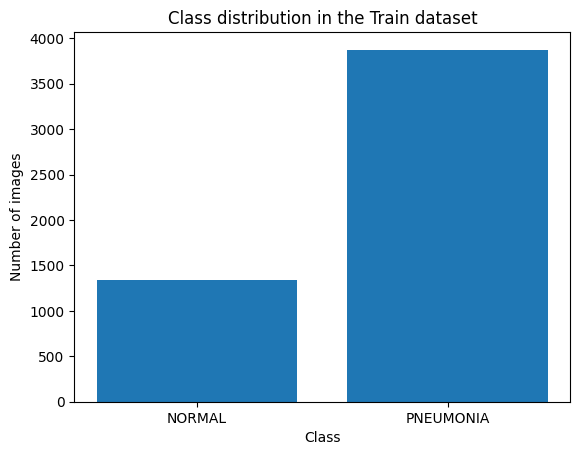

Train dataset: 0.4823, standard deviation: 0.2174


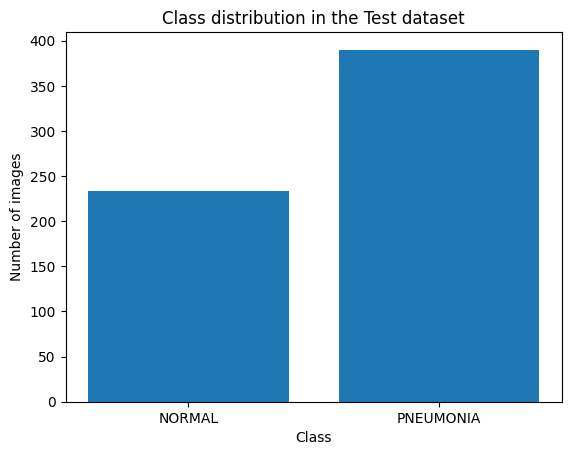

Test dataset: 0.4747, standard deviation: 0.2198


In [11]:
# Analyse the data
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

def visualize_class_distribution(dataset, dataset_name):
    class_counts = np.zeros(len(dataset.classes))
    for _, y in dataset:
        class_counts[y] += 1

    plt.bar(dataset.classes, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {dataset_name} dataset")
    plt.show()

def calculate_dataset_stats(dataset):
    mean = 0.0
    std = 0.0
    for x, _ in dataset:
        mean += x.mean()
        std += x.std()

    mean /= len(dataset)
    std /= len(dataset)

    return mean.item(), std.item()

transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='/content/chest_xray/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/chest_xray/test', transform=transform)

visualize_class_distribution(train_dataset, "Train")
mean, std = calculate_dataset_stats(train_dataset)
print(f"Train dataset: {mean:.4f}, standard deviation: {std:.4f}")

visualize_class_distribution(test_dataset, "Test")
mean, std = calculate_dataset_stats(test_dataset)
print(f"Test dataset: {mean:.4f}, standard deviation: {std:.4f}")

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Extend the lists with predictions and true labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Measures how many selected items are relevant
precision = precision_score(true_labels, predicted_labels, average='binary')

# Measures how many relevant items are selected
recall = recall_score(true_labels, predicted_labels, average='binary')

# The F1 score is the weighted average of Precision and Recall
# Measures the accuracy of the test
f1 = f1_score(true_labels, predicted_labels, average='binary')

accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.8004
Recall: 0.9462
F1 Score: 0.8672
Accuracy: 0.8189


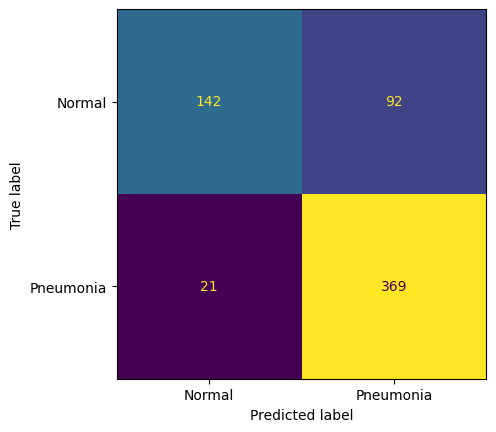

In [14]:
# Visualising the confusion matrix for statistical classification
# Used to check the performance of the algorithm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Accumulate predictions and true labels across the entire test dataset
true_labels = []
predicted_labels = []

model.eval()

# No need to calculate gradients for evaluation
with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Move predictions and true labels to CPU and extend the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(colorbar=False)

plt.show()